In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import gensim
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Activation
from keras.models import Model
import sklearn
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import save_model, load_model
from keras.callbacks import ModelCheckpoint
from nltk.tokenize import RegexpTokenizer
import seaborn as sn
from sklearn.metrics import classification_report

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
data = pd.read_csv('drive/My Drive/rusentilex.csv')

In [0]:
data = data.dropna()

In [48]:
data['term'].apply(lambda x: len(x.split(' '))).sum()

10668

In [49]:
data[:6]

,term,tone
0,остепеняться,positive
1,трудолюбивый,positive
2,беспалевный,positive
3,порядочный,positive
4,ответственнейший,positive
5,солидность,positive


In [0]:
unique_tones = data.tone.unique()

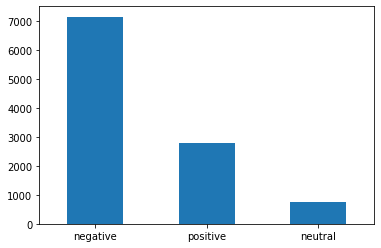

In [56]:
data.tone.value_counts().plot(kind="bar", rot = 0)

In [57]:
data.tone.value_counts()

negative    7148
positive    2774
neutral      746
Name: tone, dtype: int64

In [0]:
def tokenize(text):
  regex_tokenizer = RegexpTokenizer('[А-Яа-я]+')
  words = regex_tokenizer.tokenize(text.lower())
  stop_words = set(stopwords.words("russian"))
  without_stop_words = [w for w in words if w not in stop_words and len(w) > 1]
  return without_stop_words

In [0]:
sentences = np.array(data.term.apply(lambda x : tokenize(x)))

In [85]:
sentences[:10]

array([list(['остепеняться']), list(['трудолюбивый']),
       list(['беспалевный']), list(['порядочный']),
       list(['ответственнейший']), list(['солидность']),
       list(['самостоятельность']), list(['немаловажность']),
       list(['прогрессировать']), list(['легонький'])], dtype=object)

In [0]:
VECTOR_SIZE = 200
WINDOW_SIZE = 10
MIN_COUNT = 3
ITER_COUNT = 10
WORKERS = 4

In [0]:
# Обучение модели Word2Vec
word2vec_model = Word2Vec(sentences, min_count=1)

In [170]:
word2vec_model.most_similar('сочувствие')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('простудиться', 0.443748414516449),
 ('гадость', 0.4294304847717285),
 ('злостный', 0.36754679679870605),
 ('националистский', 0.34058812260627747),
 ('передозировать', 0.3306061029434204),
 ('царапина', 0.3304581046104431),
 ('отзывчивый', 0.32399338483810425),
 ('возвышенность', 0.31519702076911926),
 ('оживляться', 0.31408604979515076),
 ('двурушничество', 0.3131393492221832)]

In [0]:
# Преобразование названий классов в матрицу двоичных чисел (нужно для keras)
def transform_to_categorical(tones_for_each, unique_tones, build_binary_matrix = True):
  tones_to_digit = []

  for tone in tones_for_each:
    tones_to_digit.append(unique_tones.index(tone))

  if build_binary_matrix:
    tones_to_digit = to_categorical(tones_to_digit, len(unique_tones))
  
  return tones_to_digit

In [0]:
# Преобразование номеров классов в названия классов
def transform_from_categorical(prediction, unique_tones):
  answers = []

  for i in range(prediction.shape[0]):
    answers.append(unique_tones[prediction[i]])

  return answers

In [0]:
def get_model(word2vec_model, COUNT_CLASSES):
    model = Sequential() 
    model.add(word2vec_model.wv.get_keras_embedding(train_embeddings = True))
    
    model.add(Dropout(0.2))

    model.add(Conv1D(50,
                 3,
                 padding = 'valid',
                 activation = 'relu',
                 strides = 1))
    model.add(GlobalMaxPooling1D())

    model.add(Dense(250))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))

    model.add(Dense(COUNT_CLASSES, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  
    return model

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

# Преобразование всех текстов в числовые последовательности, заменяя слова на числа по словарю.
text = tokenizer.texts_to_sequences(sentences)
text = pad_sequences(text, maxlen = 10)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(text, data.tone, test_size = 0.2)

In [0]:
y_train = transform_to_categorical(y_train, unique_tones.tolist())

In [0]:
COUNT_CLASSES = unique_tones.shape[0]

In [200]:
keras_model = get_model(word2vec_model, COUNT_CLASSES)
keras_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         1074700   
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 50)          15050     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 250)               12750     
_________________________________________________________________
dropout_12 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_6 (Activation)    (None, 250)              

In [0]:
BATCH = 32
EPOCHS_COUNT = 10

In [243]:
keras_model.fit(X_train, y_train, batch_size = BATCH, epochs = EPOCHS_COUNT, validation_split = 0.2)

Train on 6827 samples, validate on 1707 samples
Epoch 1/10
6827/6827 [==============================] - 4s 556us/step - loss: 0.0025 - acc: 0.9997 - val_loss: 1.4444 - val_acc: 0.5372
Epoch 2/10
6827/6827 [==============================] - 4s 535us/step - loss: 0.0023 - acc: 0.9997 - val_loss: 1.6360 - val_acc: 0.5372
Epoch 3/10
6827/6827 [==============================] - 4s 527us/step - loss: 0.0023 - acc: 0.9997 - val_loss: 1.7657 - val_acc: 0.5372
Epoch 4/10
6827/6827 [==============================] - 4s 535us/step - loss: 0.0022 - acc: 0.9997 - val_loss: 1.5126 - val_acc: 0.5372
Epoch 5/10
6827/6827 [==============================] - 4s 547us/step - loss: 0.0020 - acc: 0.9997 - val_loss: 2.2950 - val_acc: 0.5372
Epoch 6/10
6827/6827 [==============================] - 4s 518us/step - loss: 0.0017 - acc: 0.9997 - val_loss: 2.2845 - val_acc: 0.5372
Epoch 7/10
6827/6827 [==============================] - 4s 533us/step - loss: 0.0010 - acc: 0.9997 - val_loss: 1.4567 - val_acc: 0.5372


In [0]:
test = ['супер', 'классно', 'безупречный', 'убожество', 'убивать', 'нормально', 'ужас'] 

In [0]:
#test_texts = np.array(test.apply(lambda x : tokenize(x)))
sequences_test = tokenizer.texts_to_sequences(test)
X_predict = pad_sequences(sequences_test, maxlen = X_train.shape[1])

In [0]:
prediction = keras_model.predict_classes(X_predict)

In [264]:
answers = transform_from_categorical(prediction, unique_tones.tolist())
answers

['positive',
 'positive',
 'positive',
 'negative',
 'negative',
 'positive',
 'negative']

In [0]:
keras_model.save('drive/My Drive/keras_sentiment.h5')